<h1>FLOWERS CLASSICIFATION USING DEEP LEARNING</h1>

<h3>Import Libraries</h3>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

<h3>Check for GPU Availability</h3>

In [13]:
# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")


Device: cuda


<h3>Data Loading and Augmentation</h3>

In [15]:
# 1. DATA LOADING AND SPLITTING
data_dir = "/kaggle/input/17-category-flower-dataset/17_flowers"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Define transforms for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

<h3>Dataset Loading, Splitting, and DataLoader Creation</h3>

In [17]:
# Load entire dataset using ImageFolder
dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

# Split dataset into train, val, test (70-15-15 split)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])


# DataLoaders
dataloaders = {
    'train': DataLoader(dataset_train, batch_size=32, shuffle=True),
    'val': DataLoader(dataset_val, batch_size=32, shuffle=False),
    'test': DataLoader(dataset_test, batch_size=32, shuffle=False)
}


<h3>Model Initialization, Fine-Tuning, and Optimization</h3>

In [18]:
# Use pre-trained EfficientNet-B0 and fine-tune
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 17)  # 17 flower classes
)
model = model.to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate scheduler


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h3>Model Training with Early Stopping and Learning Rate Scheduling</h3>

In [19]:
# 3. TRAINING FUNCTION
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    early_stop_counter = 0
    patience = 4

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_flower_model.pth')
                print("Model saved!")
                early_stop_counter = 0
            elif phase == 'val':
                early_stop_counter += 1
        
        # Step the scheduler
        scheduler.step()
        
        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break
    print(f'Best Val Acc: {best_acc:.4f}')
# Train the model
train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


train Loss: 1.5357 Acc: 0.5930


100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


val Loss: 0.6456 Acc: 0.8146
Model saved!
Epoch 2/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


train Loss: 0.6249 Acc: 0.8331


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


val Loss: 0.8437 Acc: 0.7697
Epoch 3/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


train Loss: 0.6499 Acc: 0.8271


100%|██████████| 6/6 [00:01<00:00,  4.07it/s]


val Loss: 0.4091 Acc: 0.8989
Model saved!
Epoch 4/25
----------


100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


train Loss: 0.4331 Acc: 0.8812


100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


val Loss: 0.4584 Acc: 0.8652
Epoch 5/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


train Loss: 0.4010 Acc: 0.8836


100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


val Loss: 0.4228 Acc: 0.8820
Epoch 6/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


train Loss: 0.3028 Acc: 0.9208


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


val Loss: 0.2523 Acc: 0.9438
Model saved!
Epoch 7/25
----------


100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


train Loss: 0.2532 Acc: 0.9316


100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


val Loss: 0.2943 Acc: 0.9101
Epoch 8/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


train Loss: 0.2123 Acc: 0.9424


100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


val Loss: 0.2325 Acc: 0.9382
Epoch 9/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


train Loss: 0.2241 Acc: 0.9268


100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


val Loss: 0.3965 Acc: 0.9045
Epoch 10/25
----------


100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


train Loss: 0.2359 Acc: 0.9400


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

val Loss: 0.2927 Acc: 0.9045
Early stopping triggered
Best Val Acc: 0.9438


<h3>Model Testing and Evaluation</h3>

/tmp/ipykernel_23/2314198153.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_flower_model.pth'))


Test Accuracy: 0.9385


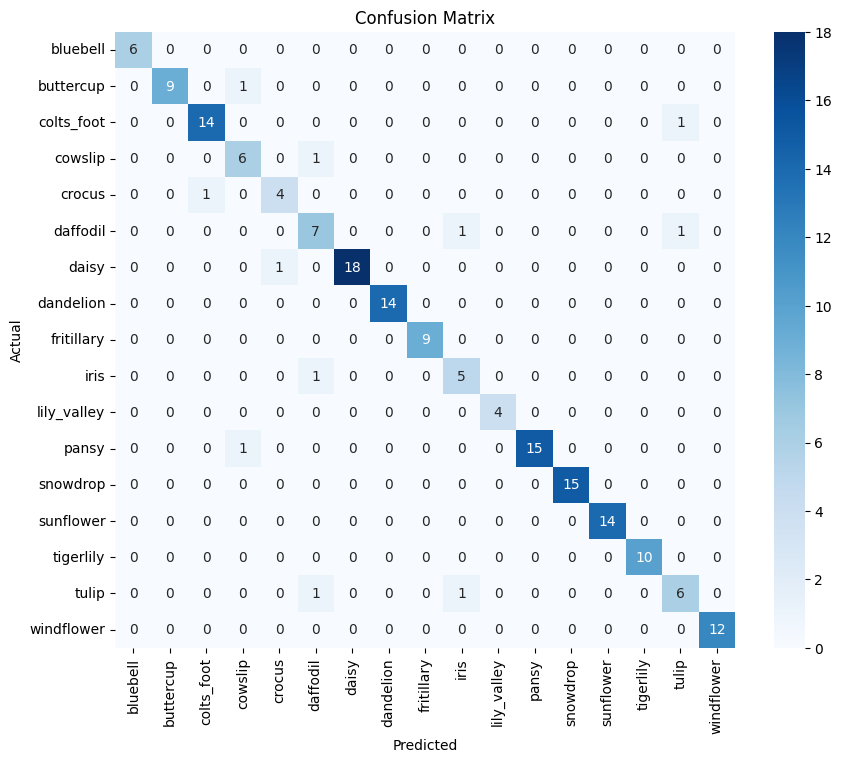

Classification Report:
              precision    recall  f1-score   support

    bluebell       1.00      1.00      1.00         6
   buttercup       1.00      0.90      0.95        10
  colts_foot       0.93      0.93      0.93        15
     cowslip       0.75      0.86      0.80         7
      crocus       0.80      0.80      0.80         5
    daffodil       0.70      0.78      0.74         9
       daisy       1.00      0.95      0.97        19
   dandelion       1.00      1.00      1.00        14
  fritillary       1.00      1.00      1.00         9
        iris       0.71      0.83      0.77         6
 lily_valley       1.00      1.00      1.00         4
       pansy       1.00      0.94      0.97        16
    snowdrop       1.00      1.00      1.00        15
   sunflower       1.00      1.00      1.00        14
   tigerlily       1.00      1.00      1.00        10
       tulip       0.75      0.75      0.75         8
  windflower       1.00      1.00      1.00        12

   

In [28]:
# 4. TESTING THE MODEL
model.load_state_dict(torch.load('best_flower_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

<h3>Save the entire model</h3>

In [29]:
torch.save(model, 'flower_model.pth')